In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from time import sleep
import pickle
import random
import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from PIL import Image
import uuid
import glob 

plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams['figure.figsize'] = (12, 8)

explain pca: https://arxiv.org/pdf/1404.1100.pdf

In [2]:
def centerData(X):
    X = X.copy()
    X -= np.mean(X, axis = 0)
    return X

In [3]:
np.random.seed(123)
x = 5*np.random.rand(100)
y = 2*x + 1 + np.random.randn(100)

x = x.reshape(100, 1)
y = y.reshape(100, 1)

X = np.hstack([x, y])
X.shape

(100, 2)

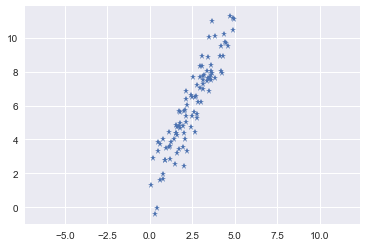

In [4]:
plt.plot(X[:,0], X[:,1], '*')
plt.axis('equal')
plt.show()

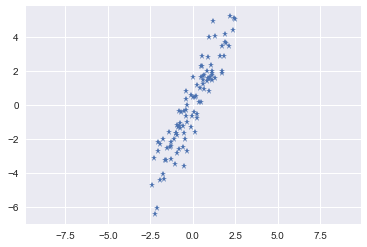

In [5]:
X_centered = centerData(X)
plt.plot(X_centered[:,0], X_centered[:,1], '*')
plt.axis('equal')
plt.show()

In [6]:
eigVals, eigVecs = np.linalg.eig(X_centered.T.dot(X_centered))
eigVecs

array([[-0.91116273, -0.41204669],
       [ 0.41204669, -0.91116273]])

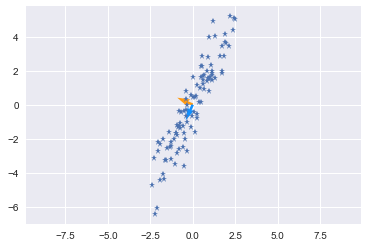

In [7]:
orange = '#FF9A13'
blue = '#1190FF'
V = eigVecs.T

origin = [0], [0] # origin point
plt.quiver(*origin, V[:,0], V[:,1], color=[orange, blue],angles='xy', scale_units='xy', scale=1)

plt.plot(X_centered[:,0], X_centered[:,1], '*')
plt.axis('equal')
plt.show()

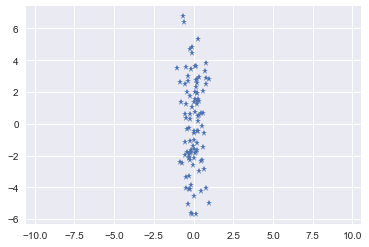

In [8]:
X_new = eigVecs.T.dot(X_centered.T)
plt.plot(X_new[0, :], X_new[1, :], '*')
plt.axis('equal')
plt.show()

### Explore real data

In [9]:
df = pd.read_csv('telco.txt', sep='\t')
df = df.dropna()
df.describe()

,tenure,age,address,income,employ,longmon,wiremon
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.526000,41.684000,11.551000,77.535000,10.987000,11.723100,11.583900
std,21.359812,12.558816,10.086681,107.044165,10.082087,10.363486,19.719426
min,1.000000,18.000000,0.000000,9.000000,0.000000,0.900000,0.000000
25%,17.000000,32.000000,3.000000,29.000000,3.000000,5.200000,0.000000
50%,34.000000,40.000000,9.000000,47.000000,8.000000,8.525000,0.000000
75%,54.000000,51.000000,18.000000,83.000000,17.000000,14.412500,24.712500
max,72.000000,77.000000,55.000000,1668.000000,47.000000,99.950000,111.950000


In [10]:
X = np.column_stack((df['longmon'].values,
                     df['tenure'].values, df['address'].values, df['age'].values, 
                     df['income'].values, df['employ'].values, 
                     df['wiremon'].values))
X_centered = centerData(X)

In [11]:
X.shape

(1000, 7)

In [12]:
eig_vals, eigVecs = np.linalg.eig(X_centered.T.dot(X_centered))
eig_vals

array([11537376.96262565,   582480.32221287,   380761.9499531 ,
         133082.08209742,    28290.74171428,    47515.57899646,
          49786.17258021])

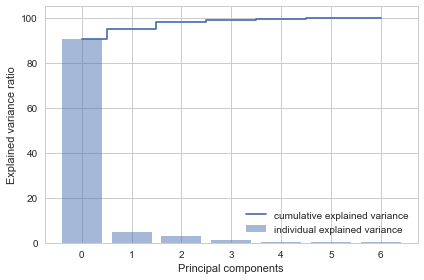

In [13]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(7), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(7), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

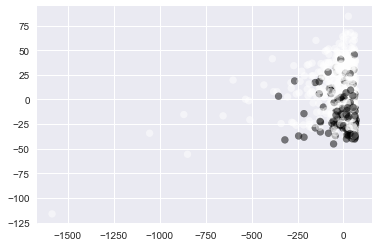

In [14]:
X_new = eigVecs.T.dot(X_centered.T)
colors = []
for ch in df['churn'].values:
    if ch=='Yes':
        colors.append(1)
    else:
        colors.append(0)
        
plt.scatter(X_new[0, :], X_new[1, :], c=colors, alpha=0.5)
#plt.axis('equal')
#plt.xlim(-125, 125)
#plt.ylim(-125, 125)
plt.show()

### Eigenfaces

In [15]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [16]:
faces.data.shape

(1348, 2914)

In [17]:
pca = PCA(25)
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

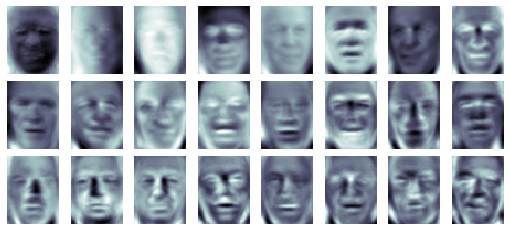

In [18]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

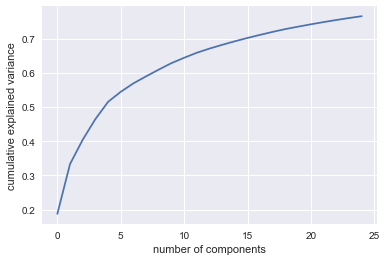

In [19]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [20]:
# Compute the components and projected faces
pca = PCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

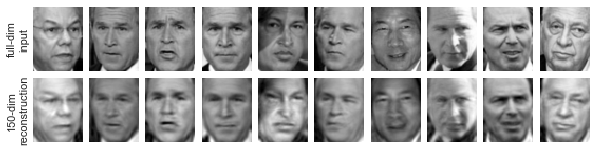

In [21]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

### Reinforcement learning

http://kvfrans.com/simple-algoritms-for-solving-cartpole/


https://www.youtube.com/watch?v=lvoHnicueoE
https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.09-Principal-Component-Analysis.ipynb#scrollTo=Zn4PuclpMpAk

In [10]:
import gym
env = gym.make('CartPole-v0')

In [11]:
def get_trining_images():
    # https://github.com/openai/gym/issues/598
    try:
        # training loop
        for i_episode in range(5):
            observation = env.reset()
            for t in range(100):
                #im_frame = env.render(mode='rgb_array')
                img = env.render(mode='rgb_array')

                im = Image.fromarray(img)
                im.save("game_screens/" + str(uuid.uuid1()) + '.jpeg')

                # print(observation)
                # print(im_frame)
                action = env.action_space.sample()
                observation, reward, done, info = env.step(action)
                if done:
                    print("Episode finished after {} timesteps".format(t+1))
                    break

    finally:
        print('---------------------DONE--------------------')
        env.close()

In [12]:
image_list = []
for filename in glob.glob('game_screens/*.jpeg'):
    im = Image.open(filename)
    # im = im.resize((120,80))
    # im = im.convert(mode='L')
    #image_list.append(list(im.getdata()))
    image_list.append(np.array(im).flatten())
    im.close()
print(len(image_list))
image_list = np.array(image_list)
image_list.shape

884


(884, 9600)

In [13]:
pca = PCA(50)
pca.fit(image_list)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

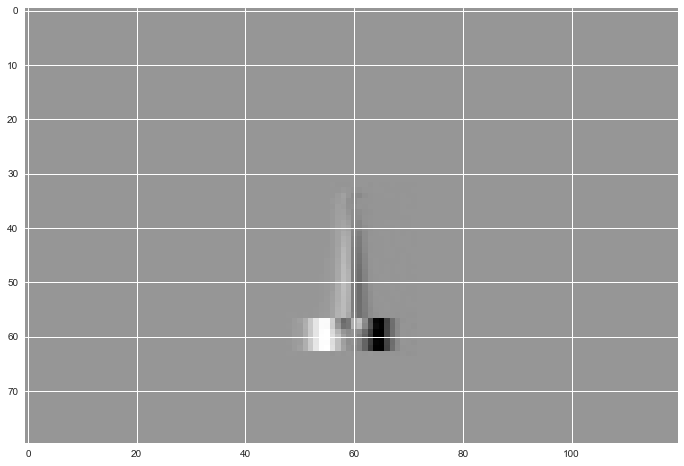

In [17]:
imgplot = plt.imshow(pca.components_[0].reshape(80,120))

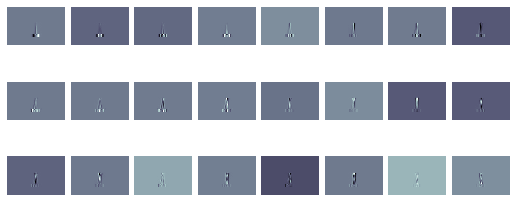

In [18]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(80, 120), cmap='bone')

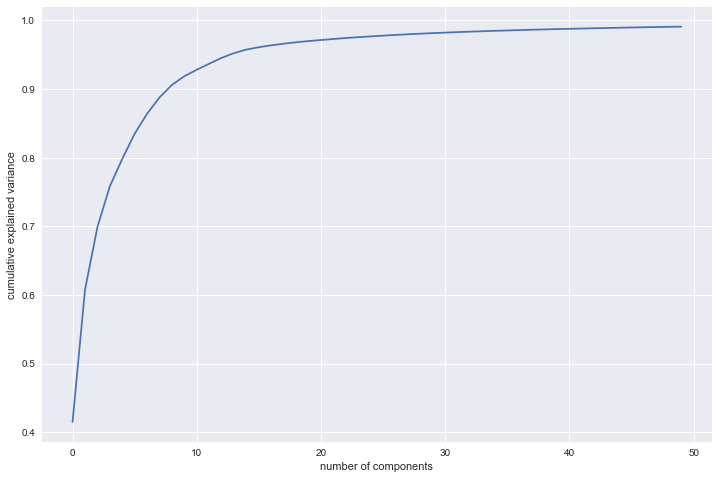

In [19]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [29]:
# a = Image.fromarray(image_list[0], mode='L')
# a.show()

# filename = 'game_screens/00c2ff42-0f74-11e9-8861-7831c1c7ab34.jpeg'
# im = Image.open(filename)
# print(im.size)
# len(list(im.getdata()))/3

In [53]:
# Compute the components and projected faces
pca = PCA(10).fit(image_list)
components = pca.transform(image_list)
projected = pca.inverse_transform(components)

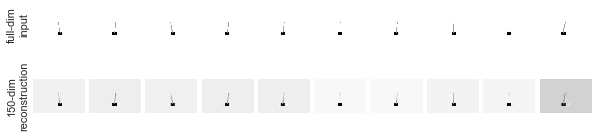

In [23]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(image_list[i].reshape(80, 120), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(80, 120), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

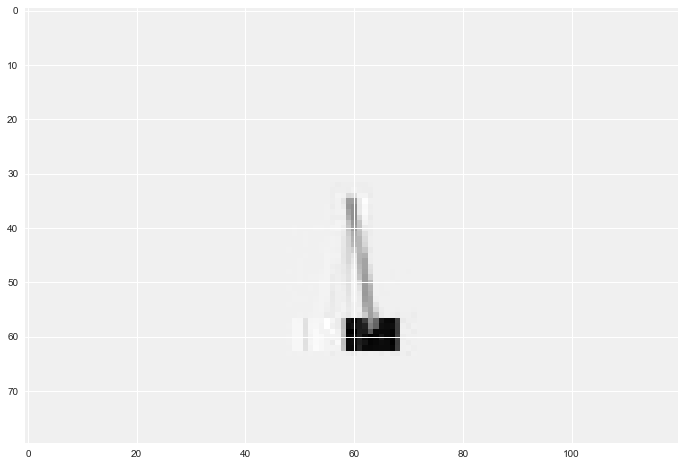

In [32]:
plt.imshow(projected[2].reshape(80,120), cmap='binary_r')

In [54]:
components[0]

array([-894.07492594,  652.2134254 , -354.84030056,  160.90654551,
         36.32332134, -285.24325032,  105.7096341 ,  -87.89301357,
        -63.22831779, -341.75821564])

### Reinforcement learning 

real


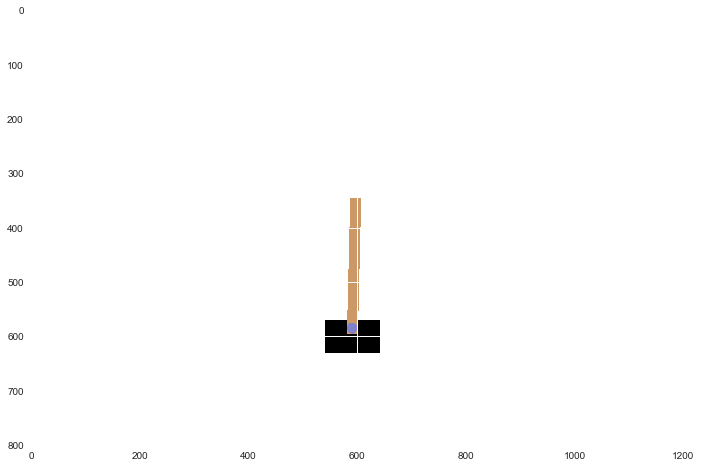

resized


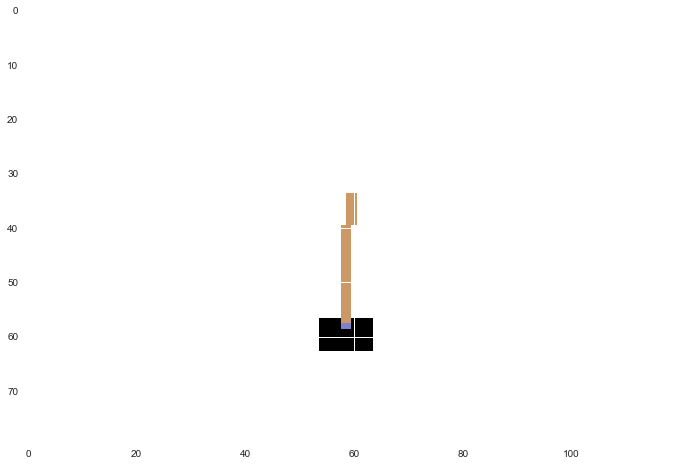

greyscale
PCA
[ 628.26905994 -218.51664043 -386.79243094 -282.58919418  233.30814018
  -77.97684112   85.41680211  -54.54449025  -85.73347689   39.99214703]
back
(80, 120)


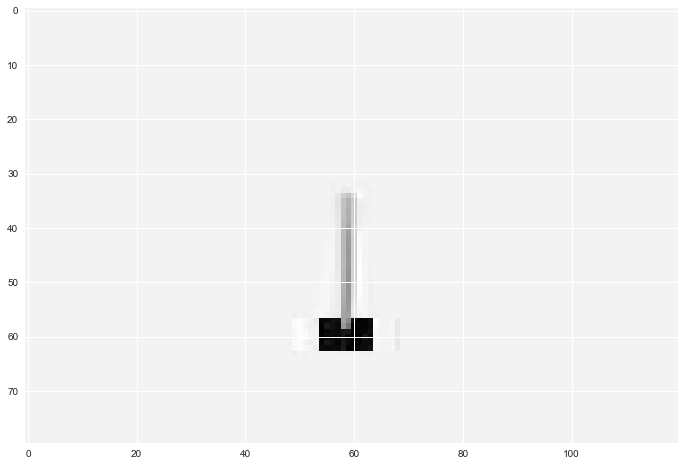

---------------------DONE--------------------
done


In [61]:
try:
    env.reset()

    pixels_state = Image.fromarray(env.render(mode='rgb_array'))
    print('real')
    plt.imshow(pixels_state, cmap='binary_r')
    plt.show()
    
    
    pixels_state = pixels_state.resize((120,80))
    print('resized')
    plt.imshow(pixels_state, cmap='binary_r')
    plt.show()
    
    
    pixels_state = pixels_state.convert(mode='L')
    print('greyscale')
    # plt.imshow(pixels_state, cmap='binary_r')
    # plt.show()

    pixels_state = np.array(pixels_state).flatten()
    pixels_state = pca.transform([pixels_state])[0]
    print('PCA')
    print(pixels_state)
    
    projected = pca.inverse_transform([pixels_state])[0].reshape((80,120))
    print('back')
    print(projected.shape)
    plt.imshow(projected, cmap='binary_r')
    plt.show()
    
finally:
    print('---------------------DONE--------------------')
    env.close()
    


print('done')

#### Simple model based on random search. State is based env state.

In [ ]:
def decide(parameters, observation):
    action = 0
    if np.matmul(parameters, observation) < 0:
        action = 0
    else 
        action = 1
    
    return action

def train():
    parameters = np.random
    
    return parameters, count

def validate(parameters):
    # run 100 games
    
    
def pipeline():
    parameters, count = train()
    print('Number of episodes to find model', count)

In [36]:
def run_episode(env, parameters):
    observation = env.reset()
    totalreward = 0
    pixels_state_prev = []
    pixels_state_prev_prev = []
    for _ in range(200):
        pixels_state = Image.fromarray(env.render(mode='rgb_array'))
        pixels_state = pixels_state.resize((120,80))
        pixels_state = pixels_state.convert(mode='L')
        
        #plt.imshow(pixels_state, cmap='binary_r')
        #plt.show()
        
        # pixels_state.save("game_screens/" + str(uuid.uuid1()) + '.jpeg')
        
        pixels_state = np.array(pixels_state).flatten()
        pixels_state = pca.transform([pixels_state])[0]
        if len(pixels_state_prev) == 0:
            # first run
            pixels_state_prev = pixels_state
            pixels_state_prev_prev = pixels_state_prev
        state = np.concatenate((pixels_state,pixels_state_prev,pixels_state_prev_prev))
        
        action = 0 if np.matmul(parameters, state) < 0 else 1
        observation, reward, done, info = env.step(action)
        # introduce noice and show that learning is impossible
        # observation += np.random.rand(4) * 2 - 1
        totalreward += reward
        pixels_state_prev_prev = pixels_state_prev
        pixels_state_prev = pixels_state
        
        if done:
            break
    return totalreward

def train():
    env = gym.make('CartPole-v0')
    
    episodes_per_update = 5
    counter = 0
    noise_scaling = 0.5  
    parameters = np.random.rand(30) * 2 - 1 
    bestreward = 0
    for _ in range(1000):
        counter += 1
        newparams = parameters + (np.random.rand(30) * 2 - 1)*noise_scaling
        reward = run_episode(env, newparams)
        
        reward = 0  
        for _ in range(episodes_per_update):  
            reward += run_episode(env,newparams)
        reward /= episodes_per_update
        
        print(reward)
        if reward > bestreward:
            print('new params')
            bestreward = reward
            parameters = newparams
            if reward == 200:
                print('super win')
                break

    return counter

# create graphs
results = []
for _ in range(3):
    # store number of episonds untill we get super win: 200
    results.append(train())

plt.hist(results,50,normed=1, facecolor='g', alpha=0.75)
plt.xlabel('Episodes required to reach 200')
plt.ylabel('Frequency')
plt.title('Histogram of Random Search')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

12.4
new params


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

KeyboardInterrupt: 

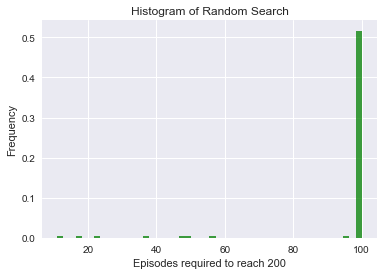

9.538


In [48]:
def run_episode(env, parameters):
    observation = env.reset()
    totalreward = 0
    for _ in range(200):
        action = 0 if np.matmul(parameters, observation) < 0 else 1
        observation, reward, done, info = env.step(action)
        observation += np.random.rand(4) * 2 - 1
        totalreward += reward
        if done:
            break
    return totalreward

def train():
    env = gym.make('CartPole-v0')
    
    counter = 0
    bestparams = None
    bestreward = 0
    for _ in range(100):
        counter += 1
        parameters = np.random.rand(4) * 2 - 1
        reward = run_episode(env,parameters)
        if reward > bestreward:
            bestreward = reward
            bestparams = parameters
            if reward == 200:
                break

    return counter

# create graphs
results = []
for _ in range(10):
    results.append(train())

plt.hist(results,50,normed=1, facecolor='g', alpha=0.75)
plt.xlabel('Episodes required to reach 200')
plt.ylabel('Frequency')
plt.title('Histogram of Random Search')
plt.show()

In [102]:
import tensorflow as tf
import numpy as np
import random
import gym
import math
import matplotlib.pyplot as plt


def softmax(x):
    e_x = np.exp(x - np.max(x))
    out = e_x / e_x.sum()
    return out


def policy_gradient():
    with tf.variable_scope("policy"):
        params = tf.get_variable("policy_parameters",[4,2])
        state = tf.placeholder("float",[None,4])
        actions = tf.placeholder("float",[None,2])
        advantages = tf.placeholder("float",[None,1])
        linear = tf.matmul(state,params)
        probabilities = tf.nn.softmax(linear)
        good_probabilities = tf.reduce_sum(tf.multiply(probabilities, actions),reduction_indices=[1])
        eligibility = tf.log(good_probabilities) * advantages
        loss = -tf.reduce_sum(eligibility)
        optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
        return probabilities, state, actions, advantages, optimizer

def value_gradient():
    with tf.variable_scope("value"):
        state = tf.placeholder("float",[None,4])
        newvals = tf.placeholder("float",[None,1])
        w1 = tf.get_variable("w1",[4,10])
        b1 = tf.get_variable("b1",[10])
        h1 = tf.nn.relu(tf.matmul(state,w1) + b1)
        w2 = tf.get_variable("w2",[10,1])
        b2 = tf.get_variable("b2",[1])
        calculated = tf.matmul(h1,w2) + b2
        diffs = calculated - newvals
        loss = tf.nn.l2_loss(diffs)
        optimizer = tf.train.AdamOptimizer(0.1).minimize(loss)
        return calculated, state, newvals, optimizer, loss

def run_episode(env, policy_grad, value_grad, sess):
    pl_calculated, pl_state, pl_actions, pl_advantages, pl_optimizer = policy_grad
    vl_calculated, vl_state, vl_newvals, vl_optimizer, vl_loss = value_grad
    observation = env.reset()
    totalreward = 0
    states = []
    actions = []
    advantages = []
    transitions = []
    update_vals = []


    for _ in range(200):
        # calculate policy
        obs_vector = np.expand_dims(observation, axis=0)
        probs = sess.run(pl_calculated,feed_dict={pl_state: obs_vector})
        action = 0 if random.uniform(0,1) < probs[0][0] else 1
        # record the transition
        states.append(observation)
        actionblank = np.zeros(2)
        actionblank[action] = 1
        actions.append(actionblank)
        # take the action in the environment
        old_observation = observation
        observation, reward, done, info = env.step(action)
        transitions.append((old_observation, action, reward))
        totalreward += reward

        if done:
            break
    for index, trans in enumerate(transitions):
        obs, action, reward = trans

        # calculate discounted monte-carlo return
        future_reward = 0
        future_transitions = len(transitions) - index
        decrease = 1
        for index2 in range(future_transitions):
            future_reward += transitions[(index2) + index][2] * decrease
            decrease = decrease * 0.97
        obs_vector = np.expand_dims(obs, axis=0)
        currentval = sess.run(vl_calculated,feed_dict={vl_state: obs_vector})[0][0]

        # advantage: how much better was this action than normal
        advantages.append(future_reward - currentval)

        # update the value function towards new return
        update_vals.append(future_reward)

    # update value function
    update_vals_vector = np.expand_dims(update_vals, axis=1)
    sess.run(vl_optimizer, feed_dict={vl_state: states, vl_newvals: update_vals_vector})
    # real_vl_loss = sess.run(vl_loss, feed_dict={vl_state: states, vl_newvals: update_vals_vector})

    advantages_vector = np.expand_dims(advantages, axis=1)
    sess.run(pl_optimizer, feed_dict={pl_state: states, pl_advantages: advantages_vector, pl_actions: actions})

    return totalreward


env = gym.make('CartPole-v0')
policy_grad = policy_gradient()
value_grad = value_gradient()
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
for i in range(2000):
    reward = run_episode(env, policy_grad, value_grad, sess)
    if reward == 200:
        print("reward 200")
        print(i)
        break
t = 0
for _ in range(1000):
    reward = run_episode(env, policy_grad, value_grad, sess)
    t += reward
print(t / 1000)

ValueError: Variable policy/policy_parameters already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-101-556df37dac9f>", line 17, in policy_gradient
    params = tf.get_variable("policy_parameters",[4,2])
  File "<ipython-input-101-556df37dac9f>", line 105, in <module>
    policy_grad = policy_gradient()
  File "/Users/odats/openai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
env = gym.make('CartPole-v0')
s0 = env.reset()

True

In [ ]:
env.observation_space

In [ ]:
def e_greedy_policy(q_table, state, env, epsilon = 0.25):
    if random.random() < epsilon:
        action = env.action_space.sample()     
    else:
        action = np.argmax(q_table[state,:])
        
    return action

def e_greedy_policy_decay(q_table, state, k, number_of_runs, env):
    epsilon = 1 - (k/number_of_runs)
    
    actions_count = env.action_space.n
    act_greedy = epsilon / actions_count + (1 - epsilon)
    
    if random.random() < act_greedy:
        action = np.argmax(q_table[state,:])
    else:
        action = env.action_space.sample()
        
    return action

def ucb_policy(q_table, state, q_table_n, k, number_of_runs, env):
    action = np.argmax(np.add(q_table[state,:], 2*(np.log(k) / q_table_n[state,:])))
    
    return action

def random_policy(q_table, state, env):
    action = env.action_space.sample()
    return action

def greedy_policy(q_table, state):
    action = np.argmax(q_table[state,:])
    return action

def evaluate_policy(env, q_table, max_episodes=1000): 
    tot_reward = 0
    for ep in range(max_episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        
        # Reward per episode
        while not done:
            action = greedy_policy(q_table, state)
            new_state, reward, done, _ = env.step(action)
            ep_reward += reward
            state = new_state
            if done:
                tot_reward += ep_reward
                
    return tot_reward / max_episodes

In [ ]:
def q_learning_train(env, number_of_runs=10000, alfa=0.5, gama=0.9, 
                     use_e_greedy_policy_decay=False, use_trace_of_learning=True):
    
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    
    trace_of_learning = []
    trace_of_won = []
    won_count = 0
    for k in tqdm(range(1, number_of_runs)):
        current_state = env.reset()
        done = False
        while not done: 
            if use_e_greedy_policy_decay:
                current_action = e_greedy_policy_decay(q_table, current_state, k, number_of_runs, env)
            else:
                current_action = e_greedy_policy(q_table, current_state, env)
            new_state, reward, done, prob = env.step(current_action)
                    
            target_action = greedy_policy(q_table, new_state)
            
            q_table[current_state][current_action] += alfa*(reward + gama* q_table[new_state][target_action] - q_table[current_state][current_action])

            current_state = new_state
      
        # trace log   
        if reward == 1:
            won_count += 1
        if use_trace_of_learning and k%1000 == 0:
            trace_of_learning.append(evaluate_policy(env, q_table))
            trace_of_won.append(won_count)
            won_count = 0
        
    return q_table, trace_of_learning, trace_of_won

In [ ]:
x =[]
y = []
number_of_try = 5
number_of_runs = 10000
q_tables = []

for i in range(number_of_try):
    q_table, trace_of_learning, trace_of_won = q_learning_train(env=env, number_of_runs=number_of_runs, alfa=0.1, gama=0.99,
                                                         use_e_greedy_policy_decay=False, use_trace_of_learning=True)
    sleep(0.1)
    # evaluate
    result = evaluate_policy(env, q_table, 100)

    # data for charts
    x.append(i)
    y.append(result)
    q_tables.append(q_table)

    # show learning
    plt.subplot(2, 1, 1)
    plt.plot(trace_of_learning)
    plt.title('Learning process')
    plt.ylabel('Results')

    plt.subplot(2, 1, 2)
    plt.plot(trace_of_won)
    plt.xlabel('tries (each step is 1000)')
    plt.ylabel('Won games over time')

    plt.show()

# total analitics    
fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='try', ylabel='results', title='AVG return from Policy')
ax.grid()

#fig.savefig(str(number_of_runs) + '_' + str(number_of_try) + '_plot.png')
plt.show()

print('Mean', np.mean(y))

